# Assignment 3 Primer

* Assignment 3 will be based on a sample of movie rating predictions from the Netflix Prize dataset.
* It includes two pregenerated splits of 10k users for about 3k movies. So there is already a train and validation split that you will use for your experiments.
* It can be a little tricky to use predefined splits in surpise, so I will show you how to do it here.
* There are many articles available that talk about the million dollar prize and what it meant for the company. A few are:
* https://towardsdatascience.com/deep-dive-into-netflixs-recommender-system-341806ae3b48
* https://www.thrillist.com/entertainment/nation/the-netflix-prize
* https://analyticsindiamag.com/how-useful-was-the-netflix-prize-really/

In [1]:
import numpy as np
import pyarrow.feather as feather
import pandas as pd

# If you are on an Intel-based machine, you can also enable scikit-learn intel optimizations.
# This does not work on an M1 / M2 Macbook, but does on older Macbooks with an Intel.
# Requires ``pip install scikit-learn-intelex''
#
# from sklearnex import patch_sklearn
# patch_sklearn()

In [2]:
import pyarrow.feather as feather
import pandas as pd
from surprise import Dataset, Reader, BaselineOnly, accuracy, SVD, SVDpp, KNNBasic, CoClustering, NMF
from surprise.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from joblib import parallel_backend
import os, psutil



In [3]:
df_train = feather.read_feather('netflix-5k.train.feather')
df_val = feather.read_feather('netflix-5k.validation.feather')
df_titles = feather.read_feather('netflix-5k.movie_titles.feather')

In [4]:
display(df_titles)

,movieID,imdb_id,imdb_date,date,title,genre
0,3,1860,1997,1997,Character,Drama
1,8,27899,2004,2004,What the #$*! Do We Know!?,Comedy|Documentary|Drama
2,16,76,1995,1996,Screamers,Action|Sci-Fi|Thriller
3,18,249,1994,1994,Immortal Beloved,Drama|Romance
4,26,7368,2004,2004,Never Die Alone,Crime|Drama|Thriller
...,...,...,...,...,...,...
4329,17761,6285,2003,2003,Levity,Drama
4330,17762,1653,1997,1997,Gattaca,Drama|Sci-Fi|Thriller
4331,17763,3813,1978,1978,Interiors,Drama
4332,17764,2396,1998,1998,Shakespeare in Love,Comedy|Drama|Romance


In [5]:
display(df_train)

,userID,movieID,rating
0,1000596,10036,4.0
1,1000596,10100,2.0
2,1000596,10209,3.0
3,1000596,10212,3.0
4,1000596,10225,3.0
...,...,...,...
1287012,99993,9683,4.0
1287013,99993,9685,4.0
1287014,99993,9800,2.0
1287015,99993,9939,5.0


In [6]:
display(df_val)

,userID,movieID,rating
0,1000596,10827,4.0
1,1000596,11089,4.0
2,1000596,11279,3.0
3,1000596,11337,3.0
4,1000596,1180,3.0
...,...,...,...
321485,99993,8764,5.0
321486,99993,9092,4.0
321487,99993,9508,4.0
321488,99993,9788,3.0


In [4]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_train[['userID','movieID',
                                      'rating']],reader)
datav = Dataset.load_from_df(df_val[['userID','movieID',
                                       'rating']],reader)
trainset = data.build_full_trainset()
NA,valset = train_test_split(datav, test_size=1.0)

print ('Run simple baseline model')
bl = BaselineOnly()
model = bl.fit(trainset)
predictions = bl.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions,verbose=False),3)))

Run simple baseline model
Estimating biases using als...
RMSE = 0.9


In [8]:
display(predictions)

[Prediction(uid=1609399, iid=1905, r_ui=5.0, est=3.6323533088154414, details={'was_impossible': False}),
 Prediction(uid=1924713, iid=9340, r_ui=3.0, est=2.990727307220833, details={'was_impossible': False}),
 Prediction(uid=336783, iid=7624, r_ui=4.0, est=3.235211080333999, details={'was_impossible': False}),
 Prediction(uid=2199465, iid=6708, r_ui=3.0, est=3.062106335195442, details={'was_impossible': False}),
 Prediction(uid=2561151, iid=5692, r_ui=5.0, est=3.0215239606732545, details={'was_impossible': False}),
 Prediction(uid=2597551, iid=16390, r_ui=4.0, est=3.8092876375805598, details={'was_impossible': False}),
 Prediction(uid=1846522, iid=7624, r_ui=4.0, est=3.4596979573827094, details={'was_impossible': False}),
 Prediction(uid=2199566, iid=5360, r_ui=5.0, est=4.032980345099584, details={'was_impossible': False}),
 Prediction(uid=1451540, iid=10461, r_ui=5.0, est=3.8758997288448755, details={'was_impossible': False}),
 Prediction(uid=319429, iid=11089, r_ui=4.0, est=4.3288337

In [5]:
# Let's build a pandas dataframe with all the predictions

def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
df = df.drop(['details'],axis=1)

In [10]:
display(df)

,uid,iid,rui,est,Iu,Ui,err
0,1609399,1905,5.0,3.632353,288,2664,1.367647
1,1924713,9340,3.0,2.990727,308,1805,0.009273
2,336783,7624,4.0,3.235211,239,2090,0.764789
3,2199465,6708,3.0,3.062106,292,285,0.062106
4,2561151,5692,5.0,3.021524,296,332,1.978476
...,...,...,...,...,...,...,...
321485,2554525,9960,3.0,3.411118,365,1732,0.411118
321486,22663,14667,3.0,3.323791,318,1120,0.323791
321487,2486918,2372,4.0,3.667155,170,1856,0.332845
321488,1739812,3153,5.0,4.787530,399,269,0.212470


## Now let's look at the API documents for the 'baseline' only model in surprise: https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration

## Or after some digging, even more informative -- https://github.com/NicolasHug/Surprise/blob/master/doc/source/prediction_algorithms.rst

In [11]:
# So let's setup a grid search based on these options. For simplicity, we will look at ALS only.

param_grid = {'bsl_options': 
                  {'method':['als'],'n_epochs':[5, 10, 20, 30, 50], 
                   'reg_i': [8, 9, 10, 11, 12], # lambda 2
                   'reg_u': [3, 4, 5, 6, 7],# lambda 3
                  }
             }

unwrapped_grid = {'method':['als'],'n_epochs':[5, 10, 20, 30, 50], 
                   'reg_i': [8, 9, 10, 11, 12], # lambda 2
                   'reg_u': [3, 4, 5, 6, 7],# lambda 3
                  }

# Seems OK. How permutations are there exactly?
from sklearn.model_selection import ParameterGrid
pg = ParameterGrid(unwrapped_grid)
print ('Total Permutations = ',len(pg))

Total Permutations =  125


In [12]:
# Now let's run it.
# I am forcing joblib to use multiprocessing to avoid problems with failed threads.
# Be conservative with the n_jobs you choose if you have limited memory. You can set
# it to -1 if you have a lot, which will use all of the cores. If it crashes, try using
# only one. Make sure you set n_jobs in both calls to the same value.

with parallel_backend('multiprocessing', n_jobs=1):
    gs = GridSearchCV(BaselineOnly, param_grid, joblib_verbose=10, cv=5,
                          measures=['rmse'], n_jobs=1)
    gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

rmse_params = gs.best_params['rmse']

bl_tuned = BaselineOnly(rmse_params)
model = bl_tuned.fit(trainset)
predictions = bl_tuned.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions,verbose=False),3)))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.3s remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.6s remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   18.2s remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   22.1s remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   25.7s remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   28.6s remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   32.1s remaining:    0.0s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

[Parallel(n_jobs=1)]: Done 625 out of 625 | elapsed: 173.9min finished


0.9021362807394795
{'bsl_options': {'method': 'als', 'n_epochs': 50, 'reg_i': 8, 'reg_u': 3}}
Estimating biases using als...
RMSE = 0.9


In [13]:
# That was really slow, so let's setup a randomized search based on these options. 
# For simplicity, we will look at ALS only.

param_grid = {'bsl_options': 
                  {'method':['als'],'n_epochs':[5, 10, 20, 30, 50], 
                   'reg_i': [8, 9, 10, 11, 12], # lambda 2
                   'reg_u': [3, 4, 5, 6, 7],# lambda 3
                  }
             }
with parallel_backend('multiprocessing', n_jobs=1):
    gs = RandomizedSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=5, n_iter=8, 
                            n_jobs=1, joblib_verbose=10)
    gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

rmse_params = gs.best_params['rmse']

bl_tuned = BaselineOnly(rmse_params)
model = bl_tuned.fit(trainset)
predictions = model.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions,verbose=False),3)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.5s remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   53.3s remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.3min remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.6min remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.9min remaining:    0.0s


Estimating biases using als...


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.2min remaining:    0.0s


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 11.4min finished


0.9021206231418087
{'bsl_options': {'method': 'als', 'n_epochs': 10, 'reg_i': 9, 'reg_u': 3}}
Estimating biases using als...
RMSE = 0.9


## Note that while my attempt to tune the BaselineOnly method did not result in any noticeable performance improvements based on RMSE, that is not entirely surprising based on how this algorithm works. My goal was to show you how to tune the parameters using two different methods, so that you could more easily test and tune other algorithms from surprise.

In [14]:
# Print the memory usage of this process. Requires you to set n_jobs=1 and ``pip install psutil''
# Use this to debug any memory issues you might be having.
# process = psutil.Process(os.getpid())
# print(process.memory_info().rss/(1024*1024))  # in MB

# Algorithm 1 - Singular Value Decomposition

In [20]:
parameters_grid = {"n_factors": [60, 70, 80, 90, 100, 110, 120, 130],
              "n_epochs": [20, 30, 40, 50, 60, 70, 80],
              "biased": [True, False],
               "init_mean": [0, 1, 2, 3, 4, 5, 6],
                "init_std_dev": [0.1, 0.30, 0.50, 0.70, 0.90, 1.10, 1.30]}

with parallel_backend('multiprocessing', n_jobs=-1):
    SVD_parameters = RandomizedSearchCV(SVD, parameters_grid, measures=['rmse', 'mae', 'mse'], cv=5, n_iter = 8, n_jobs = -1,  joblib_verbose=10)
    SVD_parameters.fit(data)

print(SVD_parameters.best_score['rmse'])
print(SVD_parameters.best_params['rmse'])

mse_parameters_SVD = SVD_parameters.best_params['mse']
rmse_parameters_SVD = SVD_parameters.best_params['rmse']
mae_parameters_SVD = SVD_parameters.best_params['mae']

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed: 26.2min remaining:  8.7min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 28.7min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 31.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 31.2min finished


0.9511265281304795
{'n_factors': 120, 'n_epochs': 20, 'biased': False, 'init_mean': 1, 'init_std_dev': 0.3}


In [21]:
SVD_rmse = SVD(n_factors = rmse_parameters_SVD['n_factors'], n_epochs = rmse_parameters_SVD['n_epochs'], biased = rmse_parameters_SVD['biased'], init_mean = rmse_parameters_SVD['init_mean'], init_std_dev = rmse_parameters_SVD['init_std_dev'])
SVD_rmse.fit(trainset)
SVD_rmse_predictions = SVD_rmse.test(valset)

SVD_mse = SVD(n_factors = mse_parameters_SVD['n_factors'], n_epochs = mse_parameters_SVD['n_epochs'], biased = mse_parameters_SVD['biased'], init_mean = mse_parameters_SVD['init_mean'], init_std_dev = mse_parameters_SVD['init_std_dev'])
SVD_mse.fit(trainset)
SVD_mse_predictions = SVD_mse.test(valset)

SVD_mae = SVD(n_factors = mae_parameters_SVD['n_factors'], n_epochs = mae_parameters_SVD['n_epochs'],biased = mae_parameters_SVD['biased'], init_mean = mae_parameters_SVD['init_mean'], init_std_dev = mae_parameters_SVD['init_std_dev'])
SVD_mae.fit(trainset)
SVD_mae_predictions = SVD_mae.test(valset)

print("mae {SVD} accuracy is:", accuracy.mae(SVD_mae_predictions, verbose = False))
print("mses {SVD} accuracy is:",accuracy.mse(SVD_mse_predictions, verbose = False))
print("rmse {SVD} accuracy is:", accuracy.rmse(SVD_rmse_predictions, verbose = False))

mae {SVD} accuracy is: 0.7285452765330812
mses {SVD} accuracy is: 0.8581979228991218
rmse {SVD} accuracy is: 0.9238543405616347


In [22]:
df = pd.DataFrame(SVD_rmse_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Ui'] = df.iid.apply(get_Ui)
df['Iu'] = df.uid.apply(get_Iu)
df['err'] = abs(df.est - df.rui)

df = df.drop(['details'],axis=1)
display(df)

,uid,iid,rui,est,Ui,Iu,err
0,1024036,1832,3.0,3.215447,522,306,0.215447
1,2070917,1509,5.0,3.902926,696,400,1.097074
2,1380322,4520,4.0,3.999458,398,296,0.000542
3,702281,10372,4.0,3.923887,404,263,0.076113
4,2088664,14218,4.0,3.856762,797,221,0.143238
...,...,...,...,...,...,...,...
321485,2248155,15062,4.0,3.187421,1607,271,0.812579
321486,2270517,8764,3.0,3.519866,1484,255,0.519866
321487,490883,2391,4.0,3.560323,1433,285,0.439677
321488,135409,4345,3.0,2.598398,1342,358,0.401602


# Algorithm 2 - KNNBasic

In [15]:
parameters_grid = {"k": [40, 50, 60, 70, 80],
              "min_k": [1, 2, 4, 8, 16]}

with parallel_backend('multiprocessing', n_jobs=-1):
    KNN_parameters = RandomizedSearchCV(KNNBasic, parameters_grid, measures=['rmse', 'mae', 'mse'], cv=5, n_iter = 8, n_jobs = -1,  joblib_verbose=10)
    KNN_parameters.fit(data)

print(KNN_parameters.best_score['rmse'])
print(KNN_parameters.best_params['rmse'])

mse_parameters_KNN = KNN_parameters.best_params['mse']
rmse_parameters_KNN = KNN_parameters.best_params['rmse']
mae_parameters_KNN = KNN_parameters.best_params['mae']

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 40.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 78.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 82.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 152.8min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed: 160.3min remaining: 53.4min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 198.9min remaining: 28.4min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 201.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 201.2min finished


0.9025356322891263
{'k': 40, 'min_k': 8}


In [17]:
KNN_rmse = KNNBasic(k = rmse_parameters_KNN['k'], min_k = rmse_parameters_KNN['min_k'])
KNN_rmse.fit(trainset)
KNN_rmse_predictions = KNN_rmse.test(valset)

KNN_mse = KNNBasic(k = mse_parameters_KNN['k'], min_k = mse_parameters_KNN['min_k'])
KNN_mse.fit(trainset)
KNN_mse_predictions = KNN_mse.test(valset)

KNN_mae = KNNBasic(k = mae_parameters_KNN['k'], min_k = mae_parameters_KNN['min_k'])
KNN_mae.fit(trainset)
KNN_mae_predictions = KNN_mae.test(valset)

print("mae {SVD} accuracy is:", accuracy.mae(KNN_mae_predictions, verbose = False))
print("mses {SVD} accuracy is:",accuracy.mse(KNN_mse_predictions, verbose = False))
print("rmse {SVD} accuracy is:", accuracy.rmse(KNN_rmse_predictions, verbose = False))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
mae {SVD} accuracy is: 0.6996161438653726
mses {SVD} accuracy is: 0.7921004615834746
rmse {SVD} accuracy is: 0.8900002593165209


In [18]:
df = pd.DataFrame(KNN_rmse_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Ui'] = df.iid.apply(get_Ui)
df['Iu'] = df.uid.apply(get_Iu)
df['err'] = abs(df.est - df.rui)

df = df.drop(['details'],axis=1)
display(df)

,uid,iid,rui,est,Ui,Iu,err
0,1024036,1832,3.0,3.299284,522,306,0.299284
1,2070917,1509,5.0,3.638717,696,400,1.361283
2,1380322,4520,4.0,3.937041,398,296,0.062959
3,702281,10372,4.0,4.022154,404,263,0.022154
4,2088664,14218,4.0,4.045802,797,221,0.045802
...,...,...,...,...,...,...,...
321485,2248155,15062,4.0,3.807824,1607,271,0.192176
321486,2270517,8764,3.0,3.623425,1484,255,0.623425
321487,490883,2391,4.0,3.547369,1433,285,0.452631
321488,135409,4345,3.0,3.476184,1342,358,0.476184


# Alogirthm 3 - NMF

In [6]:
parameters_grid = {"n_factors": [15, 30, 45, 60, 75, 90, 105],
              "n_epochs": [50, 60, 70, 80, 90, 100, 110],
              "biased": [True, False]}

with parallel_backend('multiprocessing', n_jobs=-1):
    NMF_parameters = RandomizedSearchCV(NMF, parameters_grid, measures=['rmse', 'mae', 'mse'], cv=5, n_iter = 8, n_jobs = -1,  joblib_verbose=10)
    NMF_parameters.fit(data)

print(NMF_parameters.best_score['rmse'])
print(NMF_parameters.best_params['rmse'])

mse_parameters_NMF = NMF_parameters.best_params['mse']
rmse_parameters_NMF = NMF_parameters.best_params['rmse']
mae_parameters_NMF = NMF_parameters.best_params['mae']

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed: 42.9min remaining: 14.3min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 49.4min remaining:  7.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 52.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 52.4min finished


0.8613974890930065
{'n_factors': 105, 'n_epochs': 110, 'biased': False}


In [7]:
rmse_NMF = NMF(n_factors = rmse_parameters_NMF['n_factors'], n_epochs = rmse_parameters_NMF['n_epochs'], biased = rmse_parameters_NMF['biased'])
rmse_NMF.fit(trainset)
NMF_rmse_predictions = rmse_NMF.test(valset)

mae_NMF = NMF(n_factors = mae_parameters_NMF['n_factors'], n_epochs = mae_parameters_NMF['n_epochs'],biased = mae_parameters_NMF['biased'])
mae_NMF.fit(trainset)
NMF_mae_predictions = mae_NMF.test(valset)

mse_NMF = NMF(n_factors = mse_parameters_NMF['n_factors'], n_epochs = mse_parameters_NMF['n_epochs'], biased = mse_parameters_NMF['biased'])
mse_NMF.fit(trainset)
NMF_mse_predictions = mse_NMF.test(valset)


print("mae {SVD} accuracy is:", accuracy.mae(NMF_mae_predictions, verbose = False))
print("mses {SVD} accuracy is:",accuracy.mse(NMF_mse_predictions, verbose = False))
print("rmse {SVD} accuracy is:", accuracy.rmse(NMF_rmse_predictions, verbose = False))

mae {SVD} accuracy is: 0.6701458458421166
mses {SVD} accuracy is: 0.7354765057412563
rmse {SVD} accuracy is: 0.8562184119520636


In [8]:
df = pd.DataFrame(NMF_rmse_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Ui'] = df.iid.apply(get_Ui)
df['Iu'] = df.uid.apply(get_Iu)
df['err'] = abs(df.est - df.rui)

df = df.drop(['details'],axis=1)
display(df)

,uid,iid,rui,est,Ui,Iu,err
0,1024036,1832,3.0,3.456893,522,306,0.456893
1,2070917,1509,5.0,3.593437,696,400,1.406563
2,1380322,4520,4.0,4.083582,398,296,0.083582
3,702281,10372,4.0,3.972560,404,263,0.027440
4,2088664,14218,4.0,4.183606,797,221,0.183606
...,...,...,...,...,...,...,...
321485,2248155,15062,4.0,3.727026,1607,271,0.272974
321486,2270517,8764,3.0,3.491677,1484,255,0.491677
321487,490883,2391,4.0,3.407902,1433,285,0.592098
321488,135409,4345,3.0,3.426465,1342,358,0.426465


# Algorithm 4 - CoClustering

In [11]:
parameters_grid = {"n_cltr_u": [3, 5, 7, 9, 11, 13, 15],
              "n_cltr_i": [3, 6, 9, 12, 15, 18, 21],
              "n_epochs": [20, 25, 30, 35, 40, 45, 50]}

with parallel_backend('multiprocessing', n_jobs=-1):
    coClus_parameters = RandomizedSearchCV(CoClustering, parameters_grid, measures=['rmse', 'mae', 'mse'], cv=5, n_iter = 8, n_jobs = -1,  joblib_verbose=10)
    coClus_parameters.fit(data)

print(coClus_parameters.best_score['rmse'])
print(coClus_parameters.best_params['rmse'])

mse_parameters_coClus = coClus_parameters.best_params['mse']
rmse_parameters_coClus = coClus_parameters.best_params['rmse']
mae_parameters_coClus = coClus_parameters.best_params['mae']

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 68.8min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed: 73.7min remaining: 24.6min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed: 80.5min remaining: 11.5min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 85.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 85.6min finished


0.8818104606709174
{'n_cltr_u': 9, 'n_cltr_i': 15, 'n_epochs': 50}


In [12]:
coClus_rmse = CoClustering(n_cltr_u = rmse_parameters_coClus['n_cltr_u'], n_cltr_i = rmse_parameters_coClus['n_cltr_i'], n_epochs = rmse_parameters_coClus['n_epochs'])
coClus_rmse.fit(trainset)
coClus_rmse_predictions = coClus_rmse.test(valset)

coClus_mae = CoClustering(n_cltr_u = mae_parameters_coClus['n_cltr_u'], n_cltr_i = mae_parameters_coClus['n_cltr_i'], n_epochs = mae_parameters_coClus['n_epochs'])
coClus_mae.fit(trainset)
coClus_mae_predictions = coClus_mae.test(valset)

coClus_mse = CoClustering(n_cltr_u = mse_parameters_coClus['n_cltr_u'], n_cltr_i = mse_parameters_coClus['n_cltr_i'], n_epochs = mse_parameters_coClus['n_epochs'])
coClus_mse.fit(trainset)
coClus_mse_predictions = coClus_mse.test(valset)

print("mae {SVD} accuracy is:", accuracy.mae(coClus_mae_predictions, verbose = False))
print("mses {SVD} accuracy is:",accuracy.mse(coClus_mse_predictions, verbose = False))
print("rmse {SVD} accuracy is:", accuracy.rmse(coClus_rmse_predictions, verbose = False))

mae {SVD} accuracy is: 0.6852191849912497
mses {SVD} accuracy is: 0.7720403990772148
rmse {SVD} accuracy is: 0.8755667411611463


In [13]:
df = pd.DataFrame(coClus_rmse_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Ui'] = df.iid.apply(get_Ui)
df['Iu'] = df.uid.apply(get_Iu)
df['err'] = abs(df.est - df.rui)

df = df.drop(['details'],axis=1)
display(df)

,uid,iid,rui,est,Ui,Iu,err
0,1024036,1832,3.0,3.373834,522,306,0.373834
1,2070917,1509,5.0,3.697134,696,400,1.302866
2,1380322,4520,4.0,4.429388,398,296,0.429388
3,702281,10372,4.0,4.073354,404,263,0.073354
4,2088664,14218,4.0,4.263503,797,221,0.263503
...,...,...,...,...,...,...,...
321485,2248155,15062,4.0,3.910645,1607,271,0.089355
321486,2270517,8764,3.0,3.669634,1484,255,0.669634
321487,490883,2391,4.0,3.344028,1433,285,0.655972
321488,135409,4345,3.0,3.673060,1342,358,0.673060


# Visualization

In [1]:
import matplotlib.pyplot as plot
import pandas as pd
import seaborn as sns

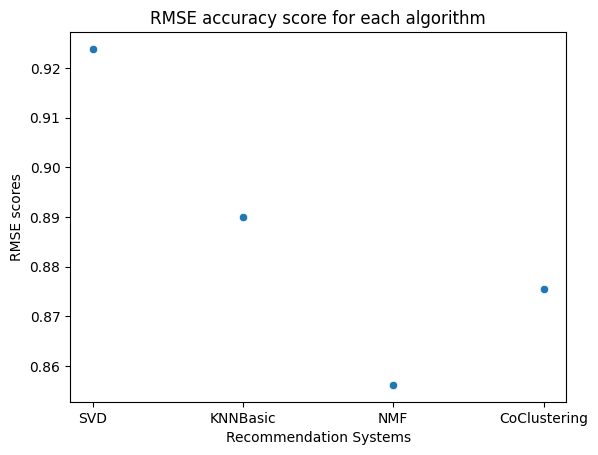

In [2]:
rmse_results = {"Recommendation Systems":["SVD", "KNNBasic", "NMF", "CoClustering"],

        "RMSE scores":[0.9238543405616347,0.8900002593165209,0.8562184119520636,0.8755667411611463]
        };
rmse_data = pd.DataFrame.from_dict(rmse_results)
sns.scatterplot(data = rmse_data, x = "Recommendation Systems", y = "RMSE scores").set(title = "RMSE accuracy score for each algorithm")
plot.show()


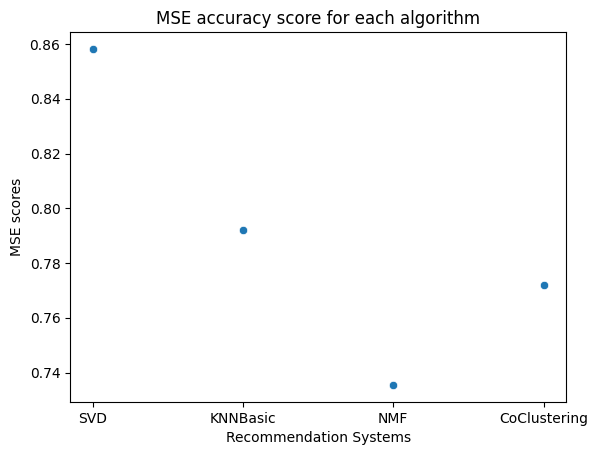

In [3]:
mse_results = {"Recommendation Systems":["SVD", "KNNBasic", "NMF", "CoClustering"],

        "MSE scores":[0.8581979228991218,0.7921004615834746,0.7354765057412563,0.7720403990772148]};
mse_data = pd.DataFrame.from_dict(mse_results)
sns.scatterplot(data = mse_data, x = "Recommendation Systems", y = "MSE scores").set(title = "MSE accuracy score for each algorithm")
plot.show()


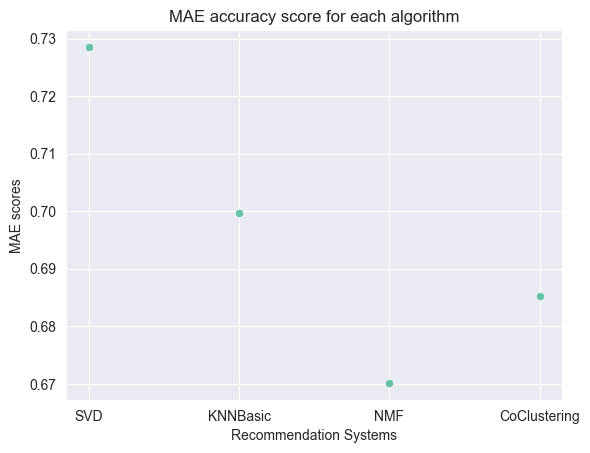

In [43]:
mae_results = {"Recommendation Systems":["SVD", "KNNBasic", "NMF", "CoClustering"],

        "MAE scores":[0.7285452765330812,0.6996161438653726,0.6701458458421166,0.6852191849912497]
        };
mae_data = pd.DataFrame.from_dict(mae_results)
sns.scatterplot(data = mae_data, x = "Recommendation Systems", y = "MAE scores").set(title = "MAE accuracy score for each algorithm")
plot.show()
